In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
from typing import List
from datetime import datetime
import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy
import matplotlib.pyplot as plt
import PIL
from torchvision.transforms import v2 as transforms
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from rigl_torch.meters import SegmentationMeter
from hydra import initialize, compose
from rigl_torch.utils.dist_utils import get_steps_to_accumulate_grad
from rigl_torch.utils.wandb_utils import init_wandb
from rigl_torch.utils.coco_eval import CocoEvaluator
from rigl_torch.utils.coco_utils import show, show_gt_vs_dt


with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "compute.distributed=False",
            "dataset=coco",
            "model=maskrcnn",
            "training.test_batch_size=2",
            "training.batch_size=2",
            "training.save_model=False",
            "wandb.log_to_wandb=False"
            ])
dotenv.load_dotenv("../.env", override=True)
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)
print(cfg.paths.base)


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

/home/pytorch/condensed-sparsity/.venv/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/pytorch/condensed-sparsity/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

maskrcnn
/home/pytorch/condensed-sparsity


In [2]:
# run_id = "2wouruyh"
# checkpoint = Checkpoint.load_best_checkpoint(run_id=run_id, checkpoint_dir="/home/pytorch/condensed-sparsity/artifacts/checkpoints/20230828_2wouruyh")

In [3]:
rank=0
checkpoint=None
if checkpoint is not None:
    run_id = checkpoint.run_id
    optimizer_state = checkpoint.optimizer
    scheduler_state = checkpoint.scheduler
    pruner_state = checkpoint.pruner
    model_state = checkpoint.model
    cfg = checkpoint.cfg
    checkpoint.cfg.wandb.log_to_wandb=False
    wandb_init_resume = "must"
else:
    run_id, optimizer_state, scheduler_state, pruner_state, model_state, wandb_init_resume = (
        None,
        None,
        None,
        None,
        None,
        None
    )

if "diet" not in cfg.rigl:
    with omegaconf.open_dict(cfg):
        cfg.rigl.diet = None
if "keep_first_layer_dense" not in cfg.rigl:
    with omegaconf.open_dict(cfg):
        cfg.rigl.keep_first_layer_dense = False
print(cfg.compute)
cfg.compute.distributed=False
wandb_init_kwargs = dict(resume=wandb_init_resume, id=run_id)
run = init_wandb(cfg, wandb_init_kwargs)
pl.seed_everything(cfg.training.seed)
use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
if not use_cuda:
    raise SystemError("GPU has stopped responding...waiting to die!")
    logger.warning(
        "Using CPU! Verify cfg.compute.no_cuda and "
        "torch.cuda.is_available() are properly set if this is unexpected"
    )

if cfg.compute.distributed and use_cuda:
    device = torch.device(f"cuda:{rank}")
else:
    print(f"loading to device rank: {rank}")
    device = torch.device(f"cuda:{rank}")
if not use_cuda:
    device = torch.device("cuda" if use_cuda else "cpu")
print(cfg.paths.base)
train_loader, test_loader = get_dataloaders(cfg)

model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name, diet=cfg.rigl.diet
)
model.to(device)
if cfg.compute.distributed:
    model = DistributedDataParallel(model, device_ids=[rank])
if model_state is not None:
    try:
        model.load_state_dict(model_state)
    except RuntimeError:
        model_state = checkpoint.get_single_process_model_state_from_distributed_state()
        model.load_state_dict(model_state)
        
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = None
if cfg.rigl.dense_allocation is not None:
    if cfg.rigl.dense_allocation is not None:
        if cfg.model.name == "skinny_resnet18":
            dense_allocation = (
                cfg.rigl.dense_allocation * cfg.model.sparsity_scale_factor
            )
            print(
                f"Scaling {cfg.rigl.dense_allocation} by "
                f"{cfg.model.sparsity_scale_factor:.2f} for SkinnyResNet18 "
                f"New Dense Alloc == {dense_allocation:.6f}"
            )
        else:
            dense_allocation = cfg.rigl.dense_allocation
        T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
        if cfg.rigl.const_fan_in:
            rigl_scheduler = RigLConstFanScheduler
        else:
            rigl_scheduler = RigLScheduler
        pruner = rigl_scheduler(
            model,
            optimizer,
            dense_allocation=cfg.rigl.dense_allocation,
            alpha=cfg.rigl.alpha,
            delta=cfg.rigl.delta,
            static_topo=cfg.rigl.static_topo,
            T_end=T_end,
            ignore_linear_layers=cfg.rigl.ignore_linear_layers,
            grad_accumulation_n=cfg.rigl.grad_accumulation_n,
            sparsity_distribution=cfg.rigl.sparsity_distribution,
            erk_power_scale=cfg.rigl.erk_power_scale,
            state_dict=pruner_state,
            filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
            static_ablation=cfg.rigl.static_ablation,
            dynamic_ablation=cfg.rigl.dynamic_ablation,
            min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
            use_sparse_init=cfg.rigl.use_sparse_initialization,
            init_method_str=cfg.rigl.init_method_str,
            use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
            initialize_grown_weights=cfg.rigl.initialize_grown_weights,
            no_ablation_module_names=cfg.model.no_ablation_module_names
        )

Global seed set to 42


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': False, 'world_size': 4, 'dist_backend': 'nccl'}
No logging to WANDB! See cfg.wandb.log_to_wandb
loading to device rank: 0
/home/pytorch/condensed-sparsity
loading annotations into memory...
Done (t=16.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


/home/pytorch/condensed-sparsity/.venv/lib/python3.10/site-packages/torchvision/models/detection/backbone_utils.py:160: UserWarning: Changing trainable_backbone_layers has not effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


In [4]:
len(test_loader.dataset)

4952

In [4]:
model.eval()
for idx, (images,targets) in enumerate(test_loader):
    break

images = [image.to(device) for image in images]
out = model(images)

No boxes found for this inference sample at threshold 0.99. Painting all boxes!


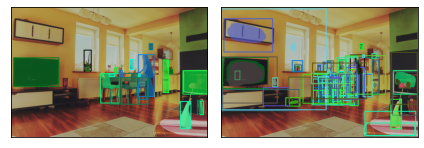

In [6]:
fig = show_gt_vs_dt(images[0], targets[0], out[0], threshold=0.99)
fig.show()

In [20]:
(out[0]["masks"][0] >= 0.5)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [30]:
len(out[0]["masks"])

100

In [28]:
len(out[0]["boxes"])

100

In [31]:
out[0]["scores"]

tensor([0.9792, 0.9605, 0.9290, 0.8558, 0.8554, 0.8313, 0.8098, 0.7816, 0.7590,
        0.7129, 0.7074, 0.6736, 0.6306, 0.6029, 0.5943, 0.5902, 0.5824, 0.5667,
        0.5463, 0.5259, 0.5203, 0.4585, 0.4561, 0.4194, 0.4012, 0.3689, 0.3602,
        0.3458, 0.3040, 0.2969, 0.2874, 0.2777, 0.2654, 0.2616, 0.2491, 0.2477,
        0.2407, 0.2367, 0.2361, 0.2355, 0.2248, 0.2170, 0.1950, 0.1938, 0.1899,
        0.1894, 0.1882, 0.1838, 0.1827, 0.1793, 0.1723, 0.1722, 0.1702, 0.1697,
        0.1679, 0.1638, 0.1632, 0.1598, 0.1511, 0.1437, 0.1428, 0.1313, 0.1312,
        0.1310, 0.1238, 0.1222, 0.1201, 0.1180, 0.1161, 0.1153, 0.1140, 0.1130,
        0.1111, 0.1051, 0.1043, 0.1038, 0.1030, 0.0973, 0.0972, 0.0961, 0.0922,
        0.0891, 0.0887, 0.0885, 0.0874, 0.0865, 0.0855, 0.0843, 0.0838, 0.0817,
        0.0796, 0.0796, 0.0794, 0.0761, 0.0738, 0.0732, 0.0720, 0.0708, 0.0705,
        0.0699], device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
from rigl_torch.utils.coco_utils import populate_null_annotation
missing_image_ids = []
_exit = False
populate_null_annotation
for idx, (x,y) in enumerate(train_loader):
    for ys in y:
        if "boxes" not in ys:
            print(ys)
            ys = populate_null_annotation(ys)
            print(ys)
            _exit = True
            break
    if _exit:
        break

{'image_id': 91705}
{'image_id': 91705, 'segmentation': [], 'area': [], 'iscrowd': [], 'bbox': [], 'category_id': [], 'id': [], 'boxes': tensor([]), 'masks': tensor([]), 'labels': tensor([])}


In [13]:
class PopulateNullAnnotations(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(x, ann):
        keys = [
            "segmentation",
            "area",
            "iscrowd",
            "image_id",
            "bbox",
            "category_id",
            "id",
        ]
        tensor_keys = [
            "boxes",
            "masks",
            "labels",
        ]
        for k in keys:
            if k not in ann:
                ann.update({k: []})
        for k in tensor_keys:
            if k not in ann:
                ann.update({k: torch.Tensor([])})
        return x, ann

In [8]:
coco = train_loader.dataset.coco
coco.imgToAnns[91705]

[]

In [10]:
from rigl_torch.utils.

{'image_id': 91705}

In [12]:
for k,v in y[0].items():
    print(k)
    print(type(v))

segmentation
<class 'list'>
area
<class 'list'>
iscrowd
<class 'list'>
image_id
<class 'int'>
bbox
<class 'list'>
category_id
<class 'list'>
id
<class 'list'>
boxes
<class 'torch.Tensor'>
masks
<class 'torch.Tensor'>
labels
<class 'torch.Tensor'>


coco.loadAnns(900100419863

In [13]:
y[0]["category_id"]

[21]

In [51]:
coco = train_loader.dataset.coco
coco.imgToAnns[227699]

[]

In [49]:
train_loader.dataset.coco.imgs[227699]

{'license': 1,
 'file_name': 'COCO_train2014_000000227699.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000227699.jpg',
 'height': 640,
 'width': 427,
 'date_captured': '2013-11-15 05:22:40',
 'flickr_url': 'http://farm5.staticflickr.com/4142/4813192617_e34557c4fe_z.jpg',
 'id': 227699}

In [47]:
train_loader.dataset.coco.__dir__()

['dataset',
 'anns',
 'cats',
 'imgs',
 'imgToAnns',
 'catToImgs',
 '__module__',
 '__init__',
 'createIndex',
 'info',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'showAnns',
 'loadRes',
 'download',
 'loadNumpyAnnotations',
 'annToRLE',
 'annToMask',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [29]:
ys['image_id']

124780

In [27]:
[k for k,v in train_loader.dataset.coco.anns.items() if v["image_id"]==ys["image_id"]]

[]

In [28]:
ys["image_id"]

124780

In [36]:
for i in train_loader.dataset.coco.dataset['annotations']:
    if i["image_id"]==124780:
        print(i)

In [31]:
train_loader.dataset.coco.dataset.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [38]:
train_loader.dataset.coco.loadAnns(900100419863)

[{'segmentation': {'counts': [133997,
    6,
    632,
    10,
    625,
    16,
    622,
    19,
    620,
    21,
    618,
    22,
    617,
    23,
    612,
    29,
    609,
    31,
    608,
    32,
    607,
    33,
    607,
    32,
    607,
    33,
    607,
    33,
    607,
    33,
    607,
    33,
    607,
    33,
    607,
    32,
    608,
    32,
    608,
    31,
    609,
    30,
    611,
    28,
    612,
    28,
    613,
    26,
    616,
    23,
    619,
    21,
    620,
    19,
    621,
    18,
    623,
    16,
    626,
    14,
    628,
    11,
    629,
    10,
    631,
    9,
    632,
    7,
    633,
    6,
    635,
    4,
    638,
    2,
    109521,
    1,
    639,
    1,
    639,
    1,
    639,
    1,
    638,
    3,
    637,
    3,
    618,
    1,
    5,
    4,
    8,
    5,
    22,
    2,
    588,
    29,
    19,
    6,
    585,
    31,
    16,
    9,
    583,
    33,
    13,
    12,
    582,
    34,
    10,
    14,
    581,
    41,
    2,
    17,
    579,
    61,
    579,
  

In [9]:
train_loader.dataset.coco.__dir__()

['dataset',
 'anns',
 'cats',
 'imgs',
 'imgToAnns',
 'catToImgs',
 '__module__',
 '__init__',
 'createIndex',
 'info',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'showAnns',
 'loadRes',
 'download',
 'loadNumpyAnnotations',
 'annToRLE',
 'annToMask',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [7]:
y[0]["boxes"]

tensor([[372.3900, 161.6200, 590.6600, 426.0000],
        [ 10.3700, 311.4000,  31.4100, 360.1900],
        [ 21.7800, 355.3500,  65.9000, 413.6100],
        [ 80.3100, 341.0100, 264.6000, 404.1500],
        [ 50.3800, 356.2900,  89.5400, 397.1900],
        [182.5400, 292.8400, 196.2100, 316.0800]])

In [6]:
y[0]["bbox"]

[[372.39, 161.62, 218.27, 264.38],
 [10.37, 311.4, 21.04, 48.79],
 [21.78, 355.35, 44.12, 58.26],
 [80.31, 341.01, 184.29, 63.14],
 [50.38, 356.29, 39.16, 40.9],
 [182.54, 292.84, 13.67, 23.24]]

In [21]:

def train(
    cfg,
    model,
    device,
    train_loader,
    optimizer,
    epoch,
    pruner,
    step,
    logger,
    rank,
):
    model.train()
    steps_to_accumulate_grad = get_steps_to_accumulate_grad(
        cfg.training.simulated_batch_size, cfg.training.batch_size
    )
    for batch_idx, (images, targets) in enumerate(train_loader):
        apply_grads = (
            True
            if steps_to_accumulate_grad == 1
            or (
                batch_idx != 0
                and (batch_idx + 1) % steps_to_accumulate_grad == 0
            )
            else False
        )
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]
        loss_dict = model(images, targets)
        # loss_dict includes losses for classification, bbox regression, masks, objectness, rpn_box regression
        losses = sum(loss for loss in loss_dict.values())
        
        # Normalize loss for accumulated grad!
        losses = losses / steps_to_accumulate_grad

        # Will call backwards hooks on model and accumulate dense grads if
        # within cfg.rigl.grad_accumulation_n mini-batch steps from update
        losses.backward()
        print(losses)

        if apply_grads:  # If we apply grads, check for topology update and log
            logger.info("Applying grads...")
            if cfg.training.clip_grad_norm is not None:
                nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=cfg.training.clip_grad_norm
                )
            step += 1
            optimizer.step()
            if pruner is not None:
                # pruner.__call__ returns False if rigl step taken
                pruner_called = not pruner()
            # optimizer.zero_grad()

            if step % cfg.training.log_interval == 0 and rank == 0:
                world_size = (
                    1
                    if cfg.compute.distributed is False
                    else cfg.compute.world_size
                )
                logger.info(
                    "Step: {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(  # noqa
                        step,
                        epoch,
                        batch_idx * len(images) * world_size,
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        losses.item(),
                    )
                )
                wandb_data = {
                    "Training Losses": losses.item(),
                }
                if pruner is not None:
                    wandb_data["ITOP Rate"] = pruner.itop_rs
                    if (
                        cfg.wandb.log_filter_stats
                        and rank == 0
                        and pruner_called
                    ):
                        # If we updated the pruner
                        # log filter-wise statistics to wandb
                        pruner.log_meters(step=step)
                wandb.log(wandb_data, step=step)

            # We zero grads after logging pruner filter meters
            optimizer.zero_grad()
            if cfg.training.dry_run:
                logger.warning("Dry run, exiting after one training step")
                return step
            if (
                cfg.training.max_steps is not None
                and step > cfg.training.max_steps
            ):
                return step
        if batch_idx == 10:
            break
    return step


def test(
    cfg, model, device, test_loader, epoch, step, rank, logger, training_meter
):
    model.eval()
    cpu_device = torch.device("cpu")
    iou_types = ["bbox", "segm"]
    evaluator = CocoEvaluator(test_loader.dataset.coco, iou_types=iou_types)
    test_loss = 0
    correct = 0
    top_k_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]
            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            res = {target["image_id"]: output for target, output in zip(targets, outputs)}
            evaluator.update(res)
            break
    if cfg.compute.distributed:
        evaluator.synchronize_between_processes()
    evaluator.accumulate()
    if rank == 0:
        logger.info(f"\nTest set summary: {evaluator.summarize()}\n")
    return evaluator

In [23]:
run = None  # No WANDB for us here
segmentation_meter = SegmentationMeter()
if not cfg.experiment.resume_from_checkpoint:
    step = 0
    if rank == 0:
        if run is None:
            run_id = datetime.now().strftime("%h-%m-%d-%H-%M")
        else:
            run_id = run.id
        checkpoint = Checkpoint(
            run_id=run_id,
            cfg=cfg,
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            pruner=pruner,
            epoch=0,
            step=step,
            parent_dir=cfg.paths.checkpoints,
        )
        if (pruner is not None) and (cfg.wandb.log_filter_stats) and cfg.wandb.log_to_wandb:
            # Log inital filter stats before pruning
            pruner.log_meters(step=step)

    epoch_start = 1
else:  # Resuming from checkpoint
    checkpoint.model = model
    checkpoint.optimizer = optimizer
    checkpoint.scheduler = scheduler
    checkpoint.pruner = pruner
    # Start at the next epoch after the last that successfully was saved
    epoch_start = checkpoint.epoch + 1
    step = checkpoint.step
    # NOTE: we will use acc for checkpointing but this will hold mask_mAP
    segmentation_meter._max_mask_mAP = checkpoint.best_acc

for epoch in range(epoch_start, cfg.training.epochs + 1):
    if pruner is not None and rank == 0:
        logger.info(pruner)
    if cfg.compute.distributed:
        train_loader.sampler.set_epoch(epoch)
    step = train(
        cfg,
        model,
        device,
        train_loader,
        optimizer,
        epoch,
        pruner=pruner,
        step=step,
        logger=logger,
        rank=rank,
    )
    # loss, box_mAP, mask_mAP = test(
    evaluator = test(
        cfg,
        model,
        device,
        test_loader,
        epoch,
        step,
        rank,
        logger,
        segmentation_meter,
    )
    if rank == 0:
        wandb.log({"Learning Rate": scheduler.get_last_lr()[0]}, step=step)
        logger.info(f"Learning Rate: {scheduler.get_last_lr()[0]}")
        bbox_mAP = evaluator.coco_eval["bbox"].stats[0]
        segm_mAP = evaluator.coco_eval["segm"].stats[0]
        checkpoint.current_acc = segm_mAP
        checkpoint.step = step
        checkpoint.epoch = epoch
        checkpoint.save_checkpoint()
    if cfg.training.dry_run:
        break
    if cfg.training.max_steps is not None and step > cfg.training.max_steps:
        break
    scheduler.step()

if cfg.training.save_model and rank == 0:
    save_path = pathlib.Path(cfg.paths.artifacts)
    if not save_path.is_dir():
        save_path.mkdir()
    f_path = save_path / f"{cfg.experiment.name}.pt"
    torch.save(model.state_dict(), f_path)
    art = wandb.Artifact(name=cfg.experiment.name, type="model")
    art.add_file(f_path)
    logging.info(f"artifact path: {f_path}")
    wandb.log_artifact(art)
if rank == 0 and cfg.wandb.log_to_wandb:
    run.finish()

INFO:__main__:RigLScheduler(
layers=74,
nonzero_params=[9408/9408, 4096/4096, 15744/36864, 16384/16384, 16384/16384, 16384/16384, 15744/36864, 16384/16384, 16384/16384, 15744/36864, 16384/16384, 32768/32768, 30720/147456, 65536/65536, 90112/131072, 65536/65536, 30720/147456, 65536/65536, 65536/65536, 30720/147456, 65536/65536, 65536/65536, 30720/147456, 65536/65536, 90368/131072, 60928/589824, 150528/262144, 180224/524288, 150784/262144, 60928/589824, 150528/262144, 150784/262144, 60928/589824, 150528/262144, 150784/262144, 60928/589824, 150528/262144, 150784/262144, 60928/589824, 150528/262144, 150784/262144, 60928/589824, 150528/262144, 180736/524288, 120832/2359296, 301056/1048576, 360448/2097152, 301056/1048576, 120832/2359296, 301056/1048576, 301056/1048576, 120832/2359296, 301056/1048576, 60416/65536, 90368/131072, 150784/262144, 271360/524288, 60928/589824, 60928/589824, 60928/589824, 60928/589824, 60928/589824, 768/768, 3072/3072, 1596416/12845056, 240640/1048576, 93184/93184, 

INFO:__main__:Applying grads...


tensor(6.2395, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(5.9305, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(6.5572, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(6.3793, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(6.0841, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(5.9151, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(5.9843, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(6.0112, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(5.9964, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(6.0789, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:Applying grads...


tensor(5.9554, device='cuda:0', grad_fn=<DivBackward0>)


INFO:__main__:
Test set summary: None



Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.0

In [35]:
evaluator.coco_eval["bbox"].stats

array([ 0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.])

In [31]:
evaluator.coco_eval["bb

In [27]:
evaluator.coco_eval["bbox"].__dir__()

['cocoGt',
 'cocoDt',
 'evalImgs',
 'eval',
 '_gts',
 '_dts',
 'params',
 '_paramsEval',
 'stats',
 'ious',
 '__module__',
 '__init__',
 '_prepare',
 'evaluate',
 'computeIoU',
 'computeOks',
 'evaluateImg',
 'accumulate',
 'summarize',
 '__str__',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__new__',
 '__repr__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [24]:
evaluator.__dir__()

['coco_gt',
 'iou_types',
 'coco_eval',
 'img_ids',
 'eval_imgs',
 '__module__',
 '__init__',
 'update',
 'synchronize_between_processes',
 'accumulate',
 'summarize',
 'prepare',
 'prepare_for_coco_detection',
 'prepare_for_coco_segmentation',
 'prepare_for_coco_keypoint',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [7]:
train_loader.dataset.coco

In [9]:
evaluator.update(res)

In [10]:
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.0

In [11]:
from pycocotools.cocoeval import COCOeval

seg_eval = COCOeval(targets[0], detections[0], iouType="segm")

AttributeError: 'dict' object has no attribute 'getImgIds'

In [ ]:
detections[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [ ]:
detections[0]["masks"]

tensor([], device='cuda:0', size=(0, 1, 478, 640))

In [ ]:
targets[0]["bbox"]

[[214.15, 41.29, 348.26, 243.78]]

In [ ]:
targets[0]["boxes"]

tensor([[214.1500,  41.2900, 562.4100, 285.0700]], device='cuda:0')

In [ ]:
targets[0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id', 'boxes', 'masks', 'labels'])

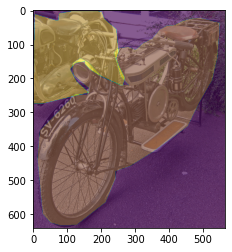

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[1].permute(1,2,0).cpu())
plt.imshow(targets[1]['masks'][0].cpu(), alpha=0.4)
plt.imshow(targets[1]['masks'][1].cpu(), alpha=0.4)

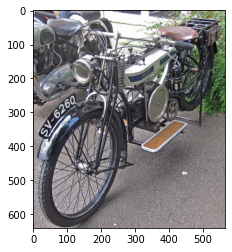

In [ ]:
plt.imshow(images[1].permute(1,2,0).cpu())

In [ ]:
targets[1]["masks"].to(torch.bool)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

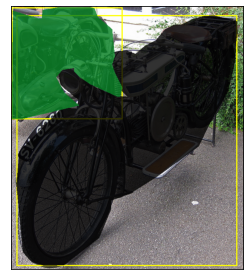

In [ ]:

    
show((images[1], targets[1]))

In [ ]:
    """Loss keys:
        {'loss_classifier': tensor(4.4969, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.6886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2162, device='cuda:0', grad_fn=<DivBackward0>)}
    """

"Loss keys:\n    {'loss_classifier': tensor(4.4969, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.6886, device='cuda:0',\n   grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6932, device='cuda:0',\n   grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2162, device='cuda:0', grad_fn=<DivBackward0>)}\n"